In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse
from astropy.io import ascii, fits
#from astropy.modeling import fitting, FittableModel, Fittable2DModel, Fittable1DModel, Parameter, custom_model
from astropy import wcs
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, PNextractor
import sep
from photutils import CircularAperture

%config InlineBackend.figure_format = 'retina'

In [2]:
# functions
#Read in Wavelength and slice to region of interest.


# Open Fits file and assign to raw_data
hdulist_2D = fits.open("FCC170_data/FCC170_reconstructed_image.fits")
flat_2D_data = hdulist_2D[0].data

hdulist = fits.open("FCC170_data/FCC170_OIII_center_cube.fits")
raw_data = hdulist[0].data
hdr = hdulist[0].header

wavelength = np.exp(hdr["CRVAL3"]+np.arange(hdr["NAXIS3"])*hdr["CDELT3"])

y_data = hdr["NAXIS2"]
x_data = hdr["NAXIS1"]

coordinates = [(n,m) for n in range(x_data) for m in range(y_data)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

raw_data_list_for_swap = np.array(raw_data).reshape(len(wavelength),x_data*y_data)
raw_data_list = np.swapaxes(raw_data_list_for_swap, 1, 0)


flatten = lambda l: [item for sublist in l for item in sublist]


<Figure size 432x288 with 0 Axes>

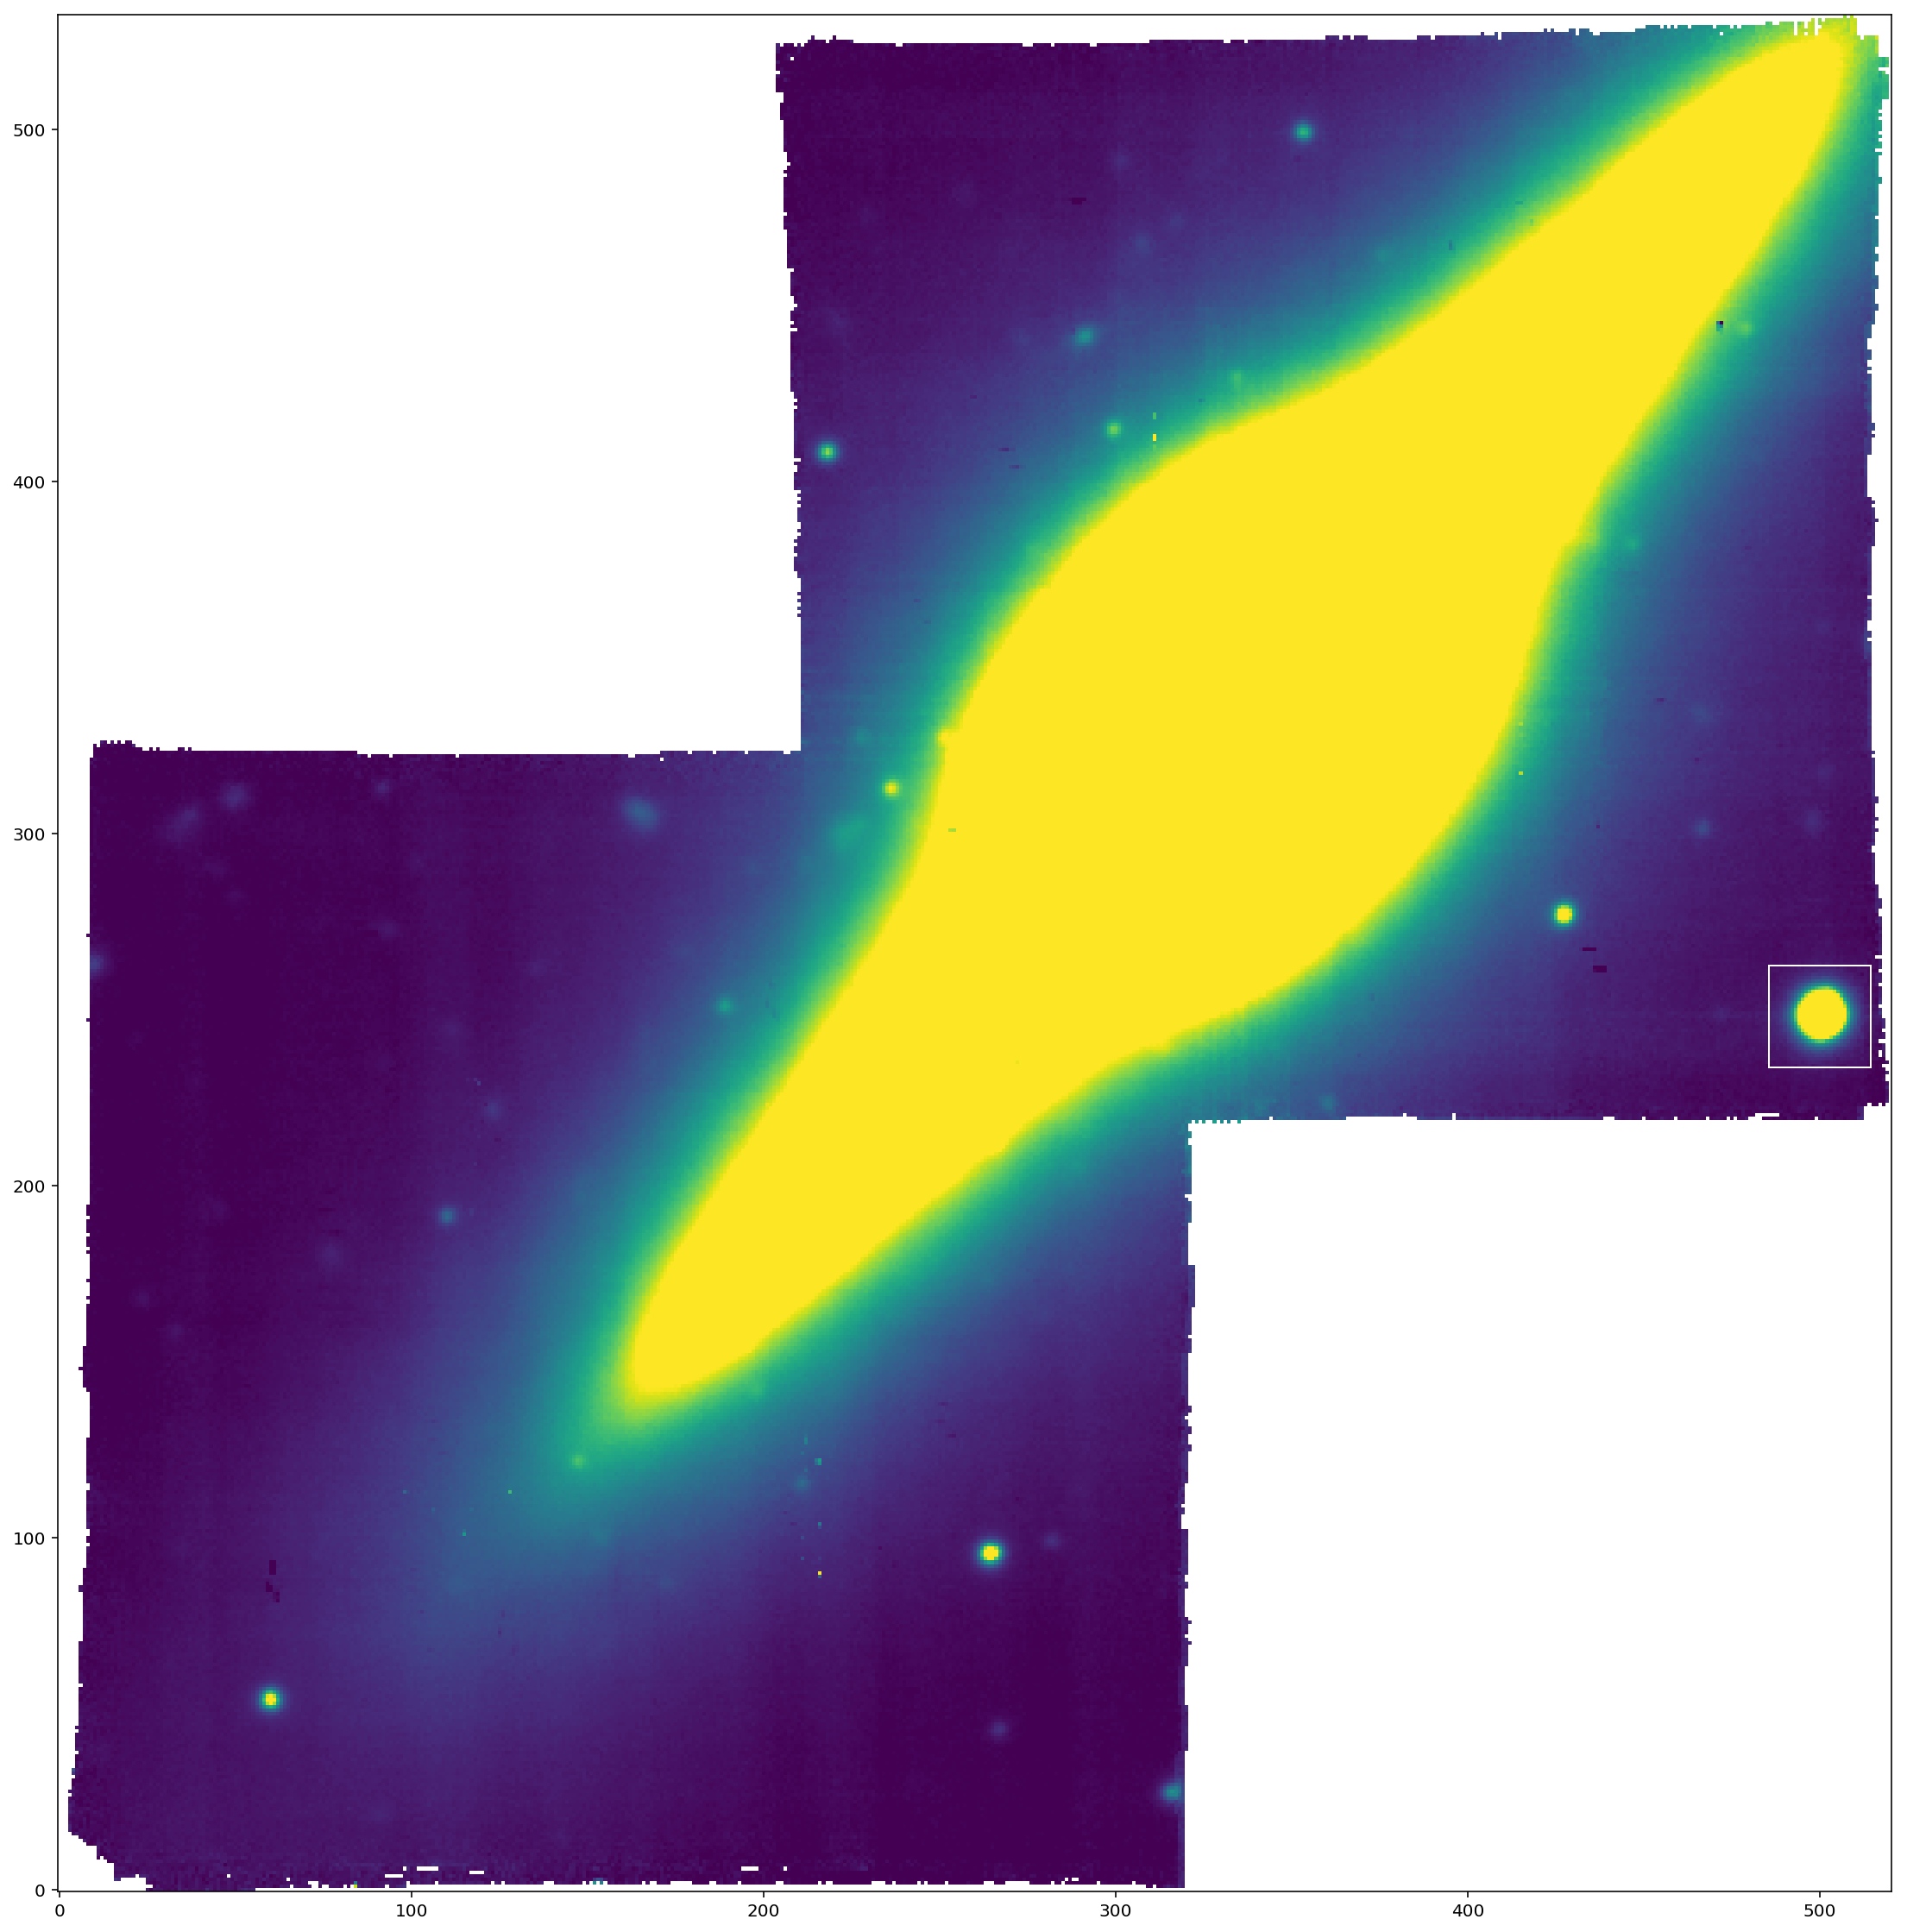

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(flat_2D_data, origin="lower", vmin=0, vmax=20000)

n_pix = 29
x=500
y=248
# select the spectra of interest
star_img = PNextractor(500,248,n_pix, flat_2D_data)
ax = plt.gca()
ax.add_patch(Rectangle((x-n_pix/2, y-n_pix/2), n_pix, n_pix, fill=False, edgecolor="white"))
plt.draw()
plt.figure(2)
#plt.imshow(test_spec, origin="lower", vmin=0, vmax=20000)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 841
    # variables        = 6
    chi-square         = 1.2676e+10
    reduced chi-square = 15180550.5
    Akaike info crit   = 13912.3555
    Bayesian info crit = 13940.7631
[[Variables]]
    moff_amp:  924007.984 +/- 2427.14726 (0.26%) (init = 900000)
    x_0:       14.4889020 +/- 0.00367525 (0.03%) (init = 14.5)
    y_0:       14.4519557 +/- 0.00367526 (0.03%) (init = 14.5)
    FWHM:      3.99881759 +/- 0.01039958 (0.26%) (init = 6)
    beta:      2.58571842 +/- 0.03610524 (1.40%) (init = 6)
    bkg:       1286.07099 +/- 184.870748 (14.37%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(moff_amp, FWHM) = -0.843
    C(FWHM, beta)     =  0.740
    C(beta, bkg)      =  0.589
    C(moff_amp, beta) = -0.585
    C(moff_amp, bkg)  = -0.288
    C(FWHM, bkg)      =  0.247
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 95
    # 

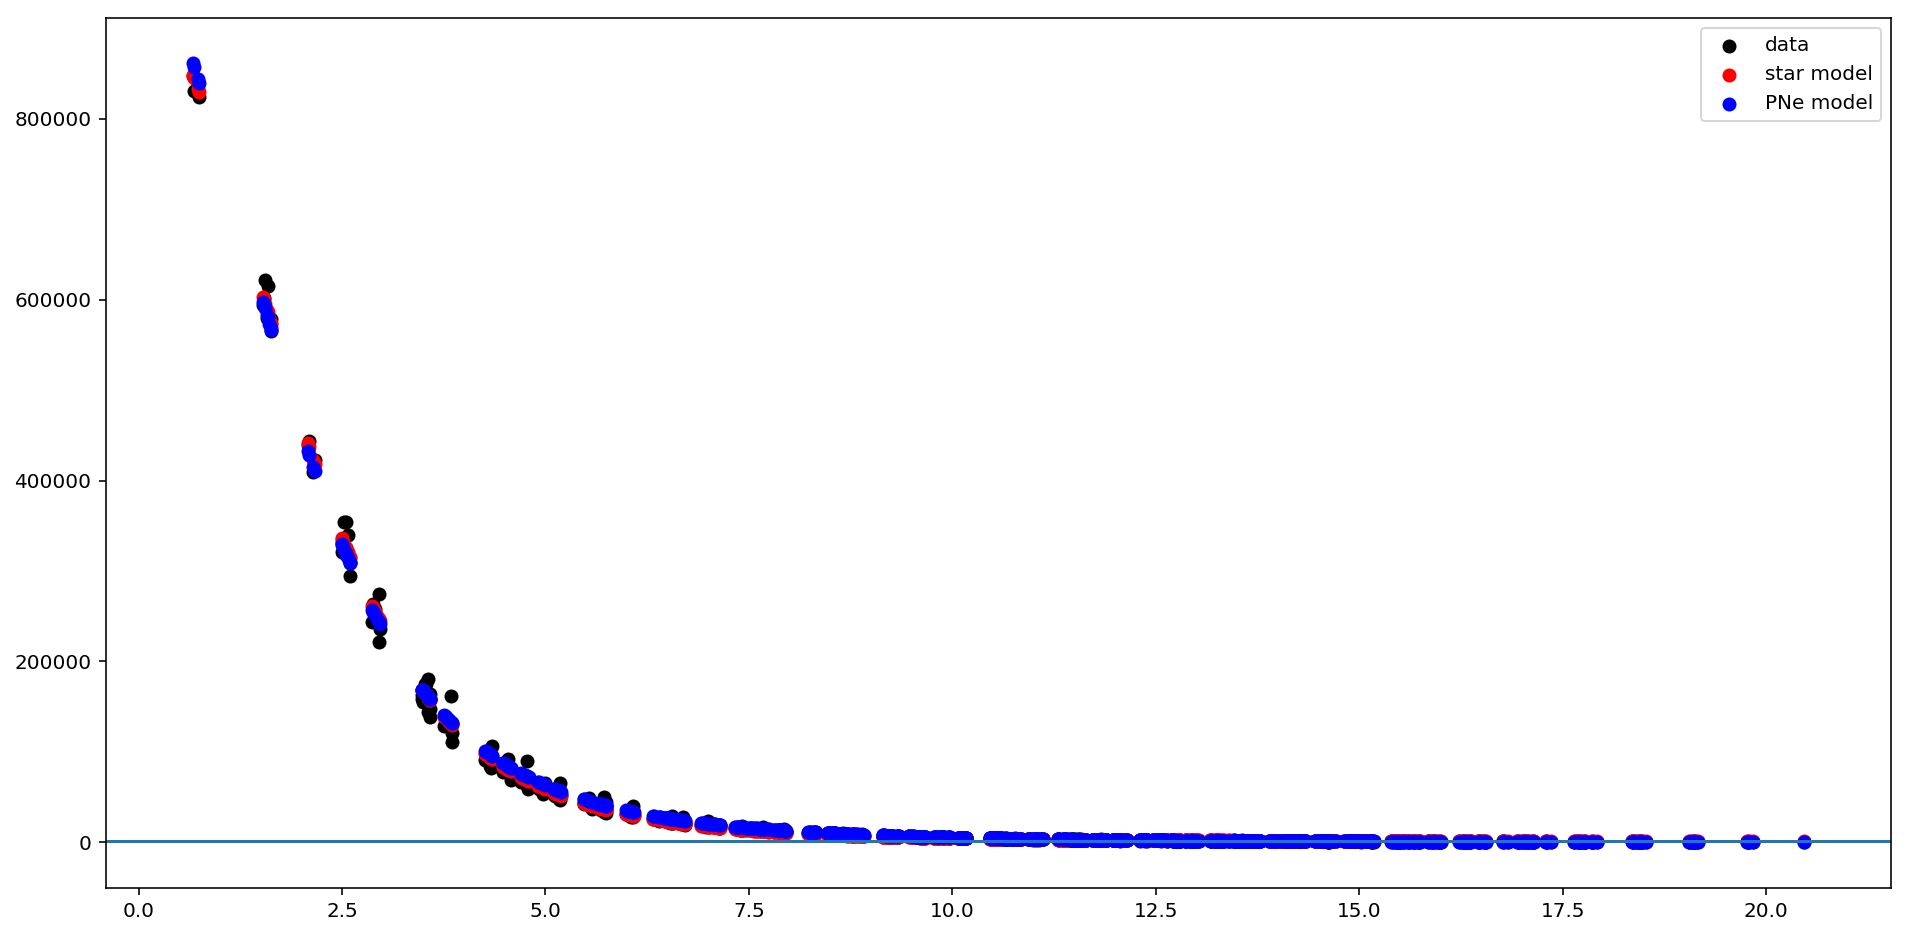

In [20]:
# 1D fit - LMfit
X_AOI, Y_AOI = np.mgrid[:n_pix,:n_pix]

coordinates = [(n,m) for n in range(n_pix) for m in range(n_pix)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

#list_of_residuals = np.zeros(len())
list_of_flux = []

def residuals(params, x_2D, y_2D, data):
    moff_amp = params["moff_amp"]
    x_0 = params["x_0"]
    y_0 = params["y_0"]
    FWHM = params["FWHM"]
    beta = params["beta"]
    bkg = params["bkg"]

    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_2D) - x_0)**2 + (np.array(y_2D) - y_0)**2) / gamma**2
    model = moff_amp * (1 + rr_gg)**(-beta) + bkg
    list_of_flux.clear()
    list_of_flux.append(model)
    #list_of_residuals[spec_num] = np.std(data - model)
    
    return data - model #/ np.std(flatten(data))

# Star initial parameters
S_params = Parameters()
S_params.add('moff_amp', value=900000., min=0.0001)
S_params.add('x_0', value=(n_pix/2), min=0001., max=n_pix)
S_params.add('y_0', value=(n_pix/2), min=0001., max=n_pix)
S_params.add('FWHM', value=6., min=0.001, max=12., vary=True)
S_params.add("beta", value=6., min=0.001, max=12., vary=True)
S_params.add("bkg", value=0.1, min=0.00001, max=10000, vary=True)

#list_of_std = [np.abs(np.std(spec)) for spec in flat_raw_data]
#input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

S_results = minimize(residuals, S_params, args=(x_fit, y_fit, star_img), nan_policy="propagate")
print(report_fit(S_results))
star_model = list_of_flux

# PNe initial Parameters
P_params = Parameters()
P_params.add('moff_amp', value=900000., min=0.0001)
P_params.add('x_0', value=(n_pix/2), min=0001., max=n_pix)
P_params.add('y_0', value=(n_pix/2), min=0001., max=n_pix)
P_params.add('FWHM', value=4.083, min=0.001, max=12., vary=True)
P_params.add("beta", value=2.122, min=0.001, max=12., vary=False)
P_params.add("bkg", value=100, min=0.00001, max=10000, vary=True)
#S_results.params["bkg"].value
#FWHM:  4.08291829123 0.106292926432
#Beta:  2.12207462875 0.195897897074


P_results = minimize(residuals, P_params, args=(x_fit, y_fit, star_img), nan_policy="propagate")
print(report_fit(P_results))
PNe_model = list_of_flux


PNe_residuals = residuals(P_results.params, x_fit, y_fit, star_img)
PNe_model = star_img - PNe_residuals

star_residuals = residuals(S_results.params, x_fit, y_fit, star_img)
star_model = star_img - star_residuals

rad= np.sqrt((x_fit - S_results.params["x_0"])**2 + (y_fit - S_results.params["y_0"])**2)
plt.figure(figsize=(16,8))
plt.scatter(rad, star_img, color="k", label="data")
plt.scatter(rad, star_model, color="r", label="star model")
plt.scatter(rad, PNe_model, color="blue", label="PNe model")
plt.axhline(1331)
plt.legend()

In [21]:
print("Star: ", np.sum(star_model))
print("PNe:  ", np.sum(PNe_model) - 1286.07099)
print("Diff: ", np.abs(np.sum(star_model)-np.sum(PNe_model)))

Star:  24688186.47954396
PNe:   25086605.614826594
Diff:  399705.2062726319


In [3]:
# Change data dimensions to wave, x*y
list_of_raw_data = np.array(raw_data).reshape(len(wavelength),x_data*y_data)
# Swap axes to x*y, wave
list_of_raw_data = np.swapaxes(list_of_raw_data, 1, 0)
# set nan values to 0.001
list_of_raw_data[np.isnan(list_of_raw_data)]=0.001
# Calculate errors from std of each spectrum
list_of_std = [np.abs(np.nanstd(spec)) for spec in list_of_raw_data]
input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

# 1D fitter

In [8]:
def Gaussian_1D_res(params, x, data, error, spec_num):
    Amp = params["Amp"]
    mean = params["mean"]
    FWHM = params["FWHM"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]
     
    Gauss_std = FWHM / 2.35482
    model = ((Gauss_bkg + Gauss_grad * x) + Amp * np.exp(- 0.5 * (x - mean)** 2 / Gauss_std**2.) +
             (Amp/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / Gauss_std**2.))
    
    list_of_rN[spec_num] = np.std(data - model)
    list_of_residuals[spec_num] = data - model
    
    return (data - model) / error


params = Parameters()
params.add("Amp",value=50., min=0.001, max=300.)
params.add("mean", value=5035., min=5000., max=5070.)
params.add("FWHM", value=2.81, vary=False) # LSF
params.add("Gauss_bkg", value=0.001, min=-500., max=500.)
params.add("Gauss_grad", value=0.001)

list_of_std = np.array([np.abs(np.std(spec)) for spec in raw_data_list])
input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

list_of_rN = np.zeros(len(raw_data_list))
list_of_residuals = np.zeros((len(raw_data_list),len(wavelength)))
list_of_residuals_from_fitter = np.zeros((len(raw_data_list),len(wavelength)))
best_fit_A = np.zeros((len(raw_data_list),2))
best_fit_mean = np.zeros((len(raw_data_list),2))


In [ ]:
for i,spectra in enumerate(raw_data_list):
    results = minimize(Gaussian_1D_res, params, args=(wavelength, spectra, input_errors[i], i), nan_policy="propagate")
    best_fit_A[i] = [results.params["Amp"], results.params["Amp"].stderr]
    best_fit_mean[i] = [results.params["mean"], results.params["mean"].stderr]
    list_of_residuals_from_fitter[i] = results.residual

In [ ]:
gauss_A = [A[0] for A in best_fit_A]
A_err = [A[1] for A in best_fit_A]

A_rN = np.array([A / rN for A,rN in zip(gauss_A, list_of_rN)])
A_rN_shape = A_rN.reshape(y_data,x_data)

Gauss_F = np.array(gauss_A) * np.sqrt(2*np.pi) * 1.19
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

In [ ]:
np.save("exported_data/FCC170/A_rN_cen", A_rN)
np.save("exported_data/FCC170/gauss_A_cen", gauss_A)
np.save("exported_data/FCC170/gauss_A_err_cen", A_err)
np.save("exported_data/FCC170/gauss_F_cen", Gauss_F)
np.save("exported_data/FCC170/list_of_resids_min_cen", list_of_residuals)
np.save("exported_data/FCC170/list_of_resids_min_obj_cen", list_of_residuals_from_fitter)
np.save("exported_data/FCC170/rN_cen", list_of_rN)

In [3]:
A_rN = np.load("exported_data/FCC170/A_rN_cen.npy")
A_rN_shape = A_rN.reshape(y_data,x_data)

gauss_A = np.load("exported_data/FCC170/gauss_A_cen.npy")
gauss_A_shape = np.array(gauss_A).reshape(y_data,x_data)

gauss_A_err = np.load("exported_data/FCC170/gauss_A_err_cen.npy")
gauss_A_err_shape = gauss_A_err.reshape(y_data, x_data)

gauss_F = np.load("exported_data/FCC170/gauss_F_cen.npy")
gauss_F_shape = np.array(gauss_F).reshape(y_data,x_data)

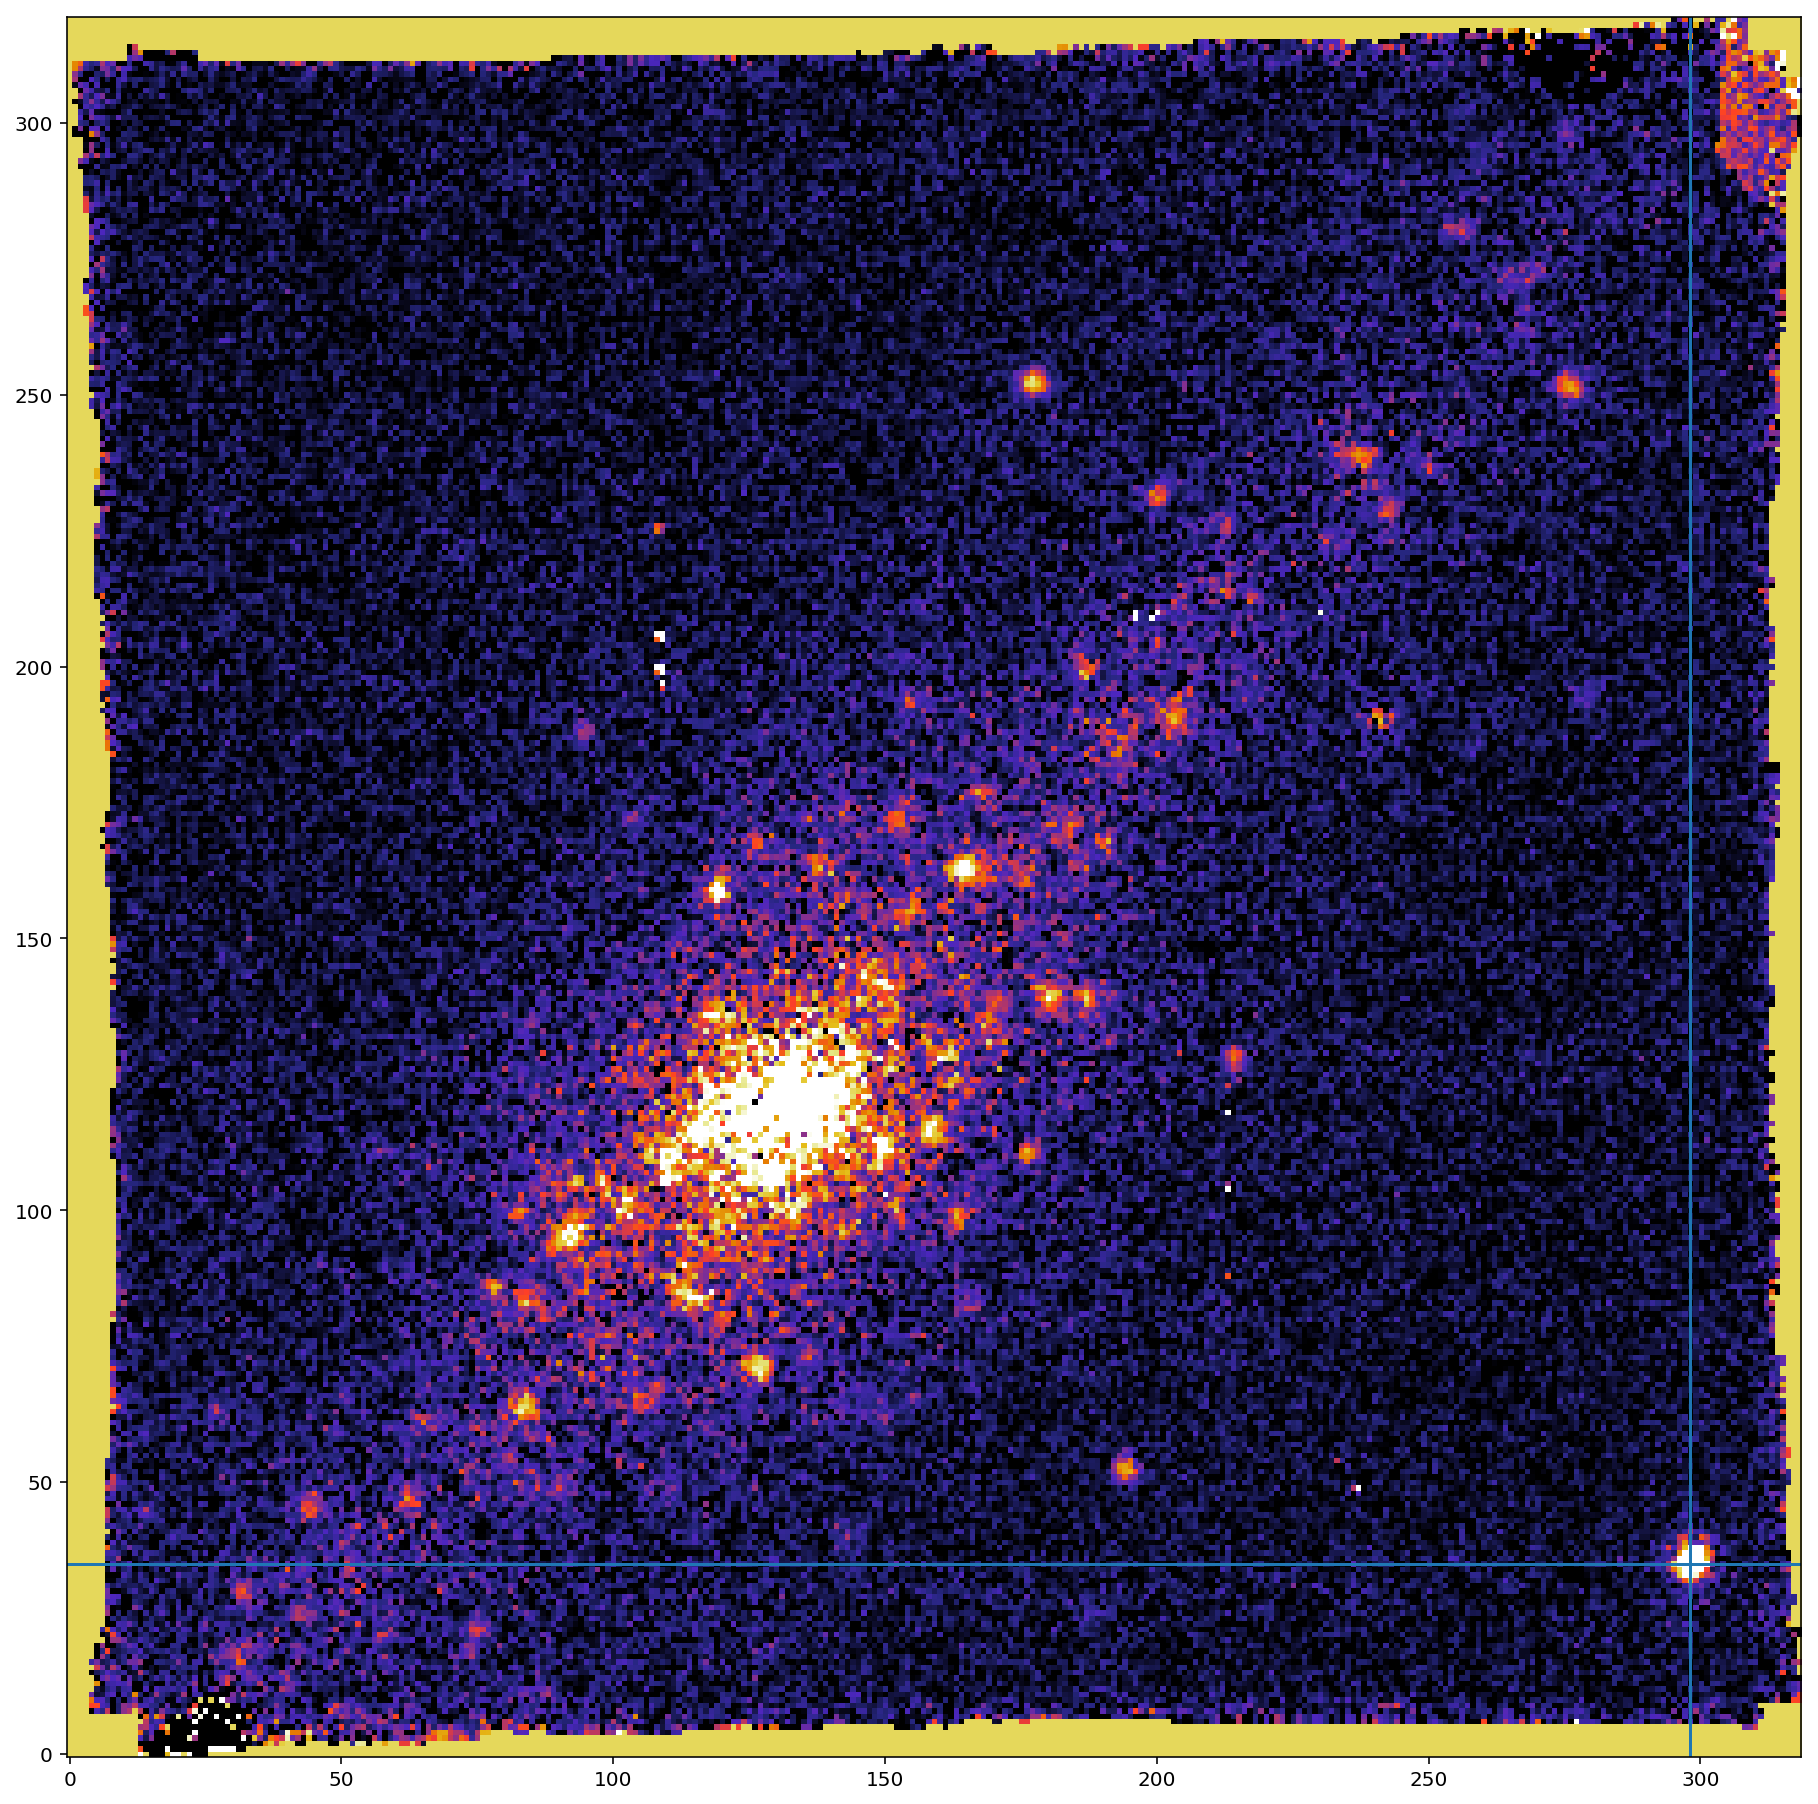

In [25]:
plt.figure(figsize=(16,16))
plt.imshow(gauss_A_shape, origin="lower", cmap="CMRmap", vmin=1., vmax=60.)

plt.axhline(35)
plt.axvline(298)

In [4]:
star_for_psf = PNextractor(298, 35, 15, gauss_A_shape)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 225
    # variables        = 5
    chi-square         = 22259.1190
    reduced chi-square = 101.177814
    Akaike info crit   = 1043.74150
    Bayesian info crit = 1060.82200
[[Variables]]
    moff_amp:  164.909869 +/- 5.67830328 (3.44%) (init = 100)
    x_0:       7.37369370 +/- 0.05340566 (0.72%) (init = 7.5)
    y_0:       7.19425282 +/- 0.05340451 (0.74%) (init = 7.5)
    FWHM:      4.33624256 +/- 0.15393119 (3.55%) (init = 6)
    beta:      2.46365530 +/- 0.39880294 (16.19%) (init = 6)
    bkg:       0.1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(moff_amp, FWHM) = -0.840
    C(FWHM, beta)     =  0.780
    C(moff_amp, beta) = -0.561
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 225
    # variables        = 3
    chi-square         = 22324.7448
    reduced chi-square = 100.561914
    Akaike 

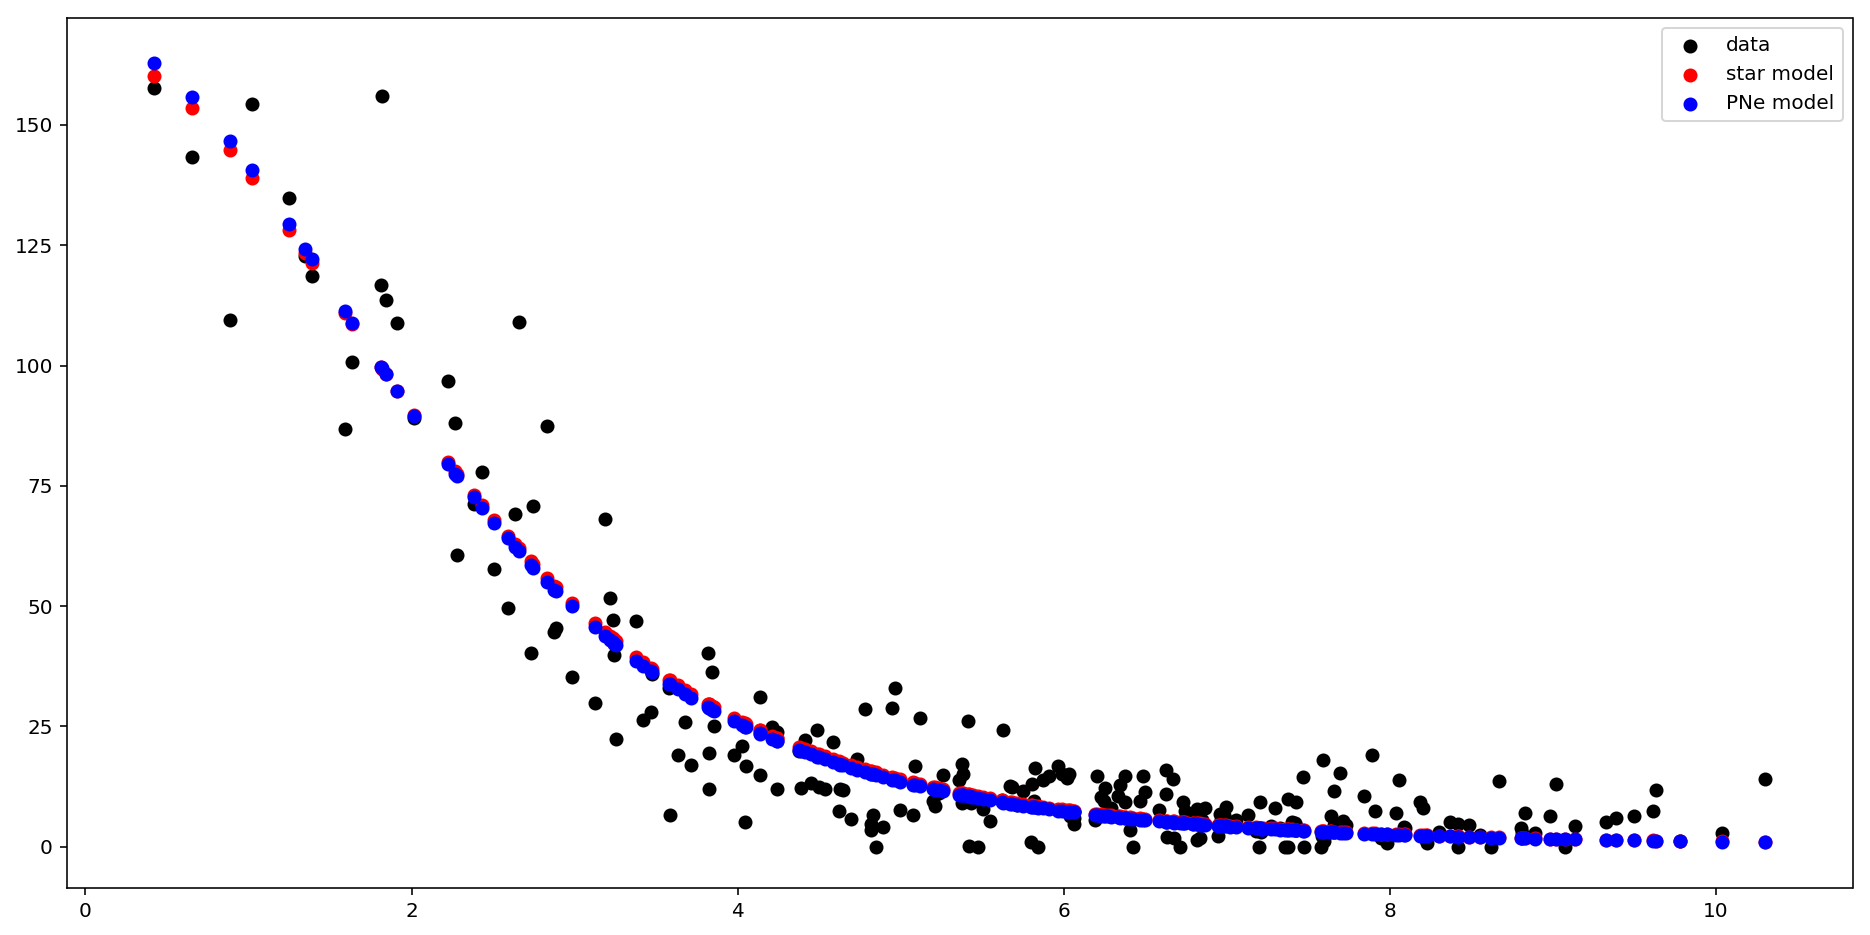

In [7]:
# 1D fit - LMfit
n_pix=15
X_AOI, Y_AOI = np.mgrid[:n_pix,:n_pix]

coordinates = [(n,m) for n in range(n_pix) for m in range(n_pix)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

#list_of_residuals = np.zeros(len())
list_of_flux = []

def residuals(params, x_2D, y_2D, data):
    moff_amp = params["moff_amp"]
    x_0 = params["x_0"]
    y_0 = params["y_0"]
    FWHM = params["FWHM"]
    beta = params["beta"]
    bkg = params["bkg"]

    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_2D) - x_0)**2 + (np.array(y_2D) - y_0)**2) / gamma**2
    model = moff_amp * (1 + rr_gg)**(-beta) + bkg
    list_of_flux.clear()
    list_of_flux.append(model)
    #list_of_residuals[spec_num] = np.std(data - model)
    
    return data - model #/ np.std(flatten(data))

# Star initial parameters
S_params = Parameters()
S_params.add('moff_amp', value=100., min=0.0001)
S_params.add('x_0', value=(n_pix/2), min=0001., max=n_pix)
S_params.add('y_0', value=(n_pix/2), min=0001., max=n_pix)
S_params.add('FWHM', value=6., min=0.001, max=30., vary=True)
S_params.add("beta", value=6., min=0.001, max=30000., vary=True)
S_params.add("bkg", value=0.1, min=0.00001, max=10000, vary=False)

#list_of_std = [np.abs(np.std(spec)) for spec in flat_raw_data]
#input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

S_results = minimize(residuals, S_params, args=(x_fit, y_fit, star_for_psf), nan_policy="propagate")
print(report_fit(S_results))
star_model = list_of_flux

# PNe initial Parameters
P_params = Parameters()
P_params.add('moff_amp', value=100., min=0.0001)
P_params.add('x_0', value=(n_pix/2), min=0001., max=n_pix)
P_params.add('y_0', value=(n_pix/2), min=0001., max=n_pix)
P_params.add('FWHM', value=4.26, min=0.001, max=30., vary=False)
P_params.add("beta", value=2.46, min=0.001, max=30000., vary=False)
P_params.add("bkg", value=S_results.params["bkg"], min=0.00001, max=10000, vary=False)
#S_results.params["bkg"].value
#FWHM:  4.08291829123 0.106292926432
#Beta:  2.12207462875 0.195897897074


P_results = minimize(residuals, P_params, args=(x_fit, y_fit, star_for_psf), nan_policy="propagate")
print(report_fit(P_results))
PNe_model = list_of_flux


PNe_residuals = residuals(P_results.params, x_fit, y_fit, star_for_psf)
PNe_model = star_for_psf - PNe_residuals

star_residuals = residuals(S_results.params, x_fit, y_fit, star_for_psf)
star_model = star_for_psf - star_residuals

rad= np.sqrt((x_fit - S_results.params["x_0"])**2 + (y_fit - S_results.params["y_0"])**2)
plt.figure(figsize=(16,8))
plt.scatter(rad, star_for_psf, color="k", label="data")
plt.scatter(rad, star_model, color="r", label="star model")
plt.scatter(rad, PNe_model, color="blue", label="PNe model")
#plt.axhline(1331)
plt.legend()

In [9]:
print("Star: ", np.sum(star_model))
print("PNe:  ", np.sum(PNe_model))
print("Diff: ", np.abs(np.sum(star_model)-np.sum(PNe_model)))

Star:  4747.22728366
PNe:   4681.40397806
Diff:  65.8233056014


In [11]:
temp_A_rN = A_rN_shape
temp_A_rN[A_rN_shape==A_rN_shape[0,0]] = np.nan

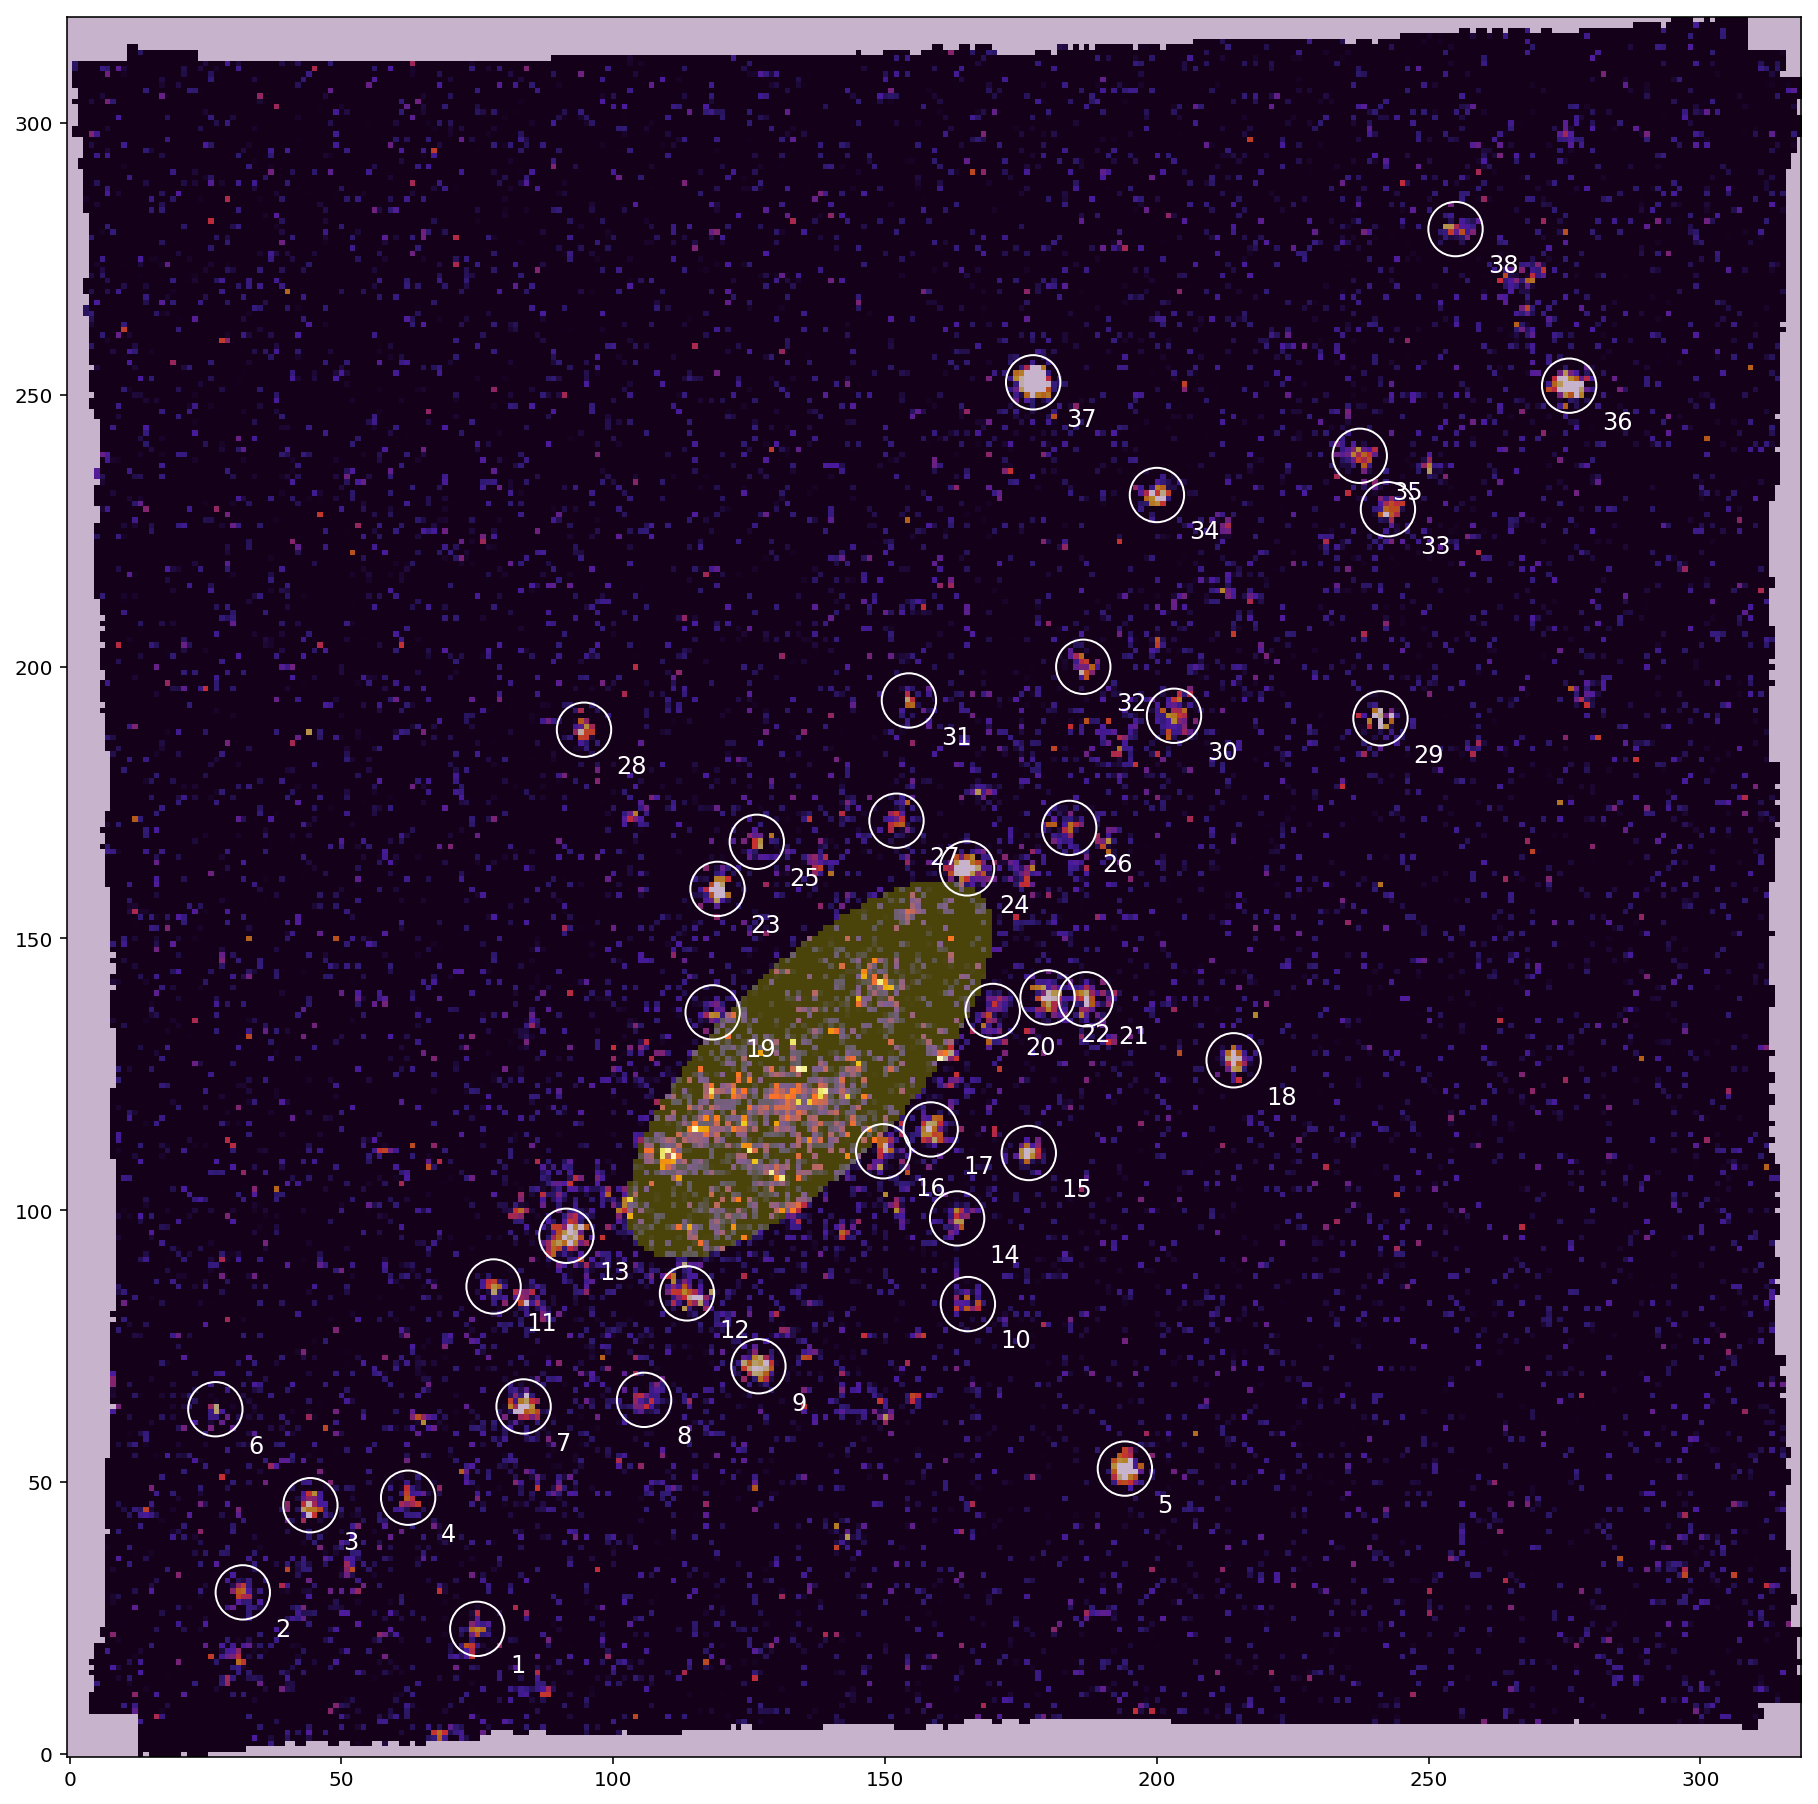

In [19]:
X, Y = np.mgrid[:y_data, :x_data]

wide=36
long=90
x_loc=126
y_loc=136

alpha = -.76
elip_mask = (((Y-y_loc) * np.cos(alpha) + (X-x_loc) * np.sin(alpha)) / (wide/2.)) ** 2 + (((Y-y_loc) * np.sin(alpha) - (X-x_loc) * np.cos(alpha)) / (long/2.)) ** 2 <= 1

objects = sep.extract(temp_A_rN, thresh=2.8, clean=True, mask=elip_mask,)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=5)
plt.figure(figsize=(16,16))
plt.imshow(temp_A_rN, origin="lower", cmap="CMRmap", vmin=2., vmax=6.)
plt.imshow(elip_mask, alpha=0.3, origin="lower")
apertures.plot(color="white")

x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]

ax = plt.gca()
#elip = Ellipse((y_loc,x_loc), wide, long, angle=137.0, fill=False, color="white")
#ax.add_artist(elip)

for i, item in enumerate(x_y_list):
    ax.annotate(i+1, (item[0]+6, item[1]-8), color="white", size=12)
    
np.save("exported_data/FCC170/x_y_list_cen", x_y_list)

In [10]:
A_rN_shape[0,3]

7.363714209603927